<a href="https://colab.research.google.com/github/Apoorva-Bedekar/Twitter-Sentiment-Classification-using-Deep-Learning/blob/main/Twitter_Sentiment_Analysis_COMP47650_21201694.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP47650 - Deep Learning Project 

## Twitter Sentiment Analysis 

### Submitted by - Apoorva Bedekar (21201694)

> In this project I will be using B.2 (Text) Classification dataset. It is a Twitter sentiment analysis for multi-class clasiification for analysing polarity of the sentiment. The following are my target classes :
 1. Extremely Negative
 2. Negative
 3. Neutral 
 4. Positive 
 5. Extremely Positive

 

#### Importing required libraries

In [2]:
import pandas as pd
import nltk

from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import logging
import warnings
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt='%H:%M:%S', level=logging.INFO)
warnings.filterwarnings("ignore")
from google.colab import files

#### Loading Data 

In [30]:
train = files.upload()
test = files.upload()

Saving Corona_NLP_train.csv to Corona_NLP_train (1).csv


Saving Corona_NLP_test.csv to Corona_NLP_test (1).csv


In [31]:
train= pd.read_csv(io.BytesIO(train['Corona_NLP_train.csv']), encoding='latin-1')
test = pd.read_csv(io.BytesIO(test['Corona_NLP_test.csv']),encoding='latin-1')

#### Initital analysis of the data

1.   Training and testing shape 
2.   Memory usage



In [32]:
print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Training Set Shape = (41157, 6)
Training Set Memory Usage = 1.88 MB
Test Set Shape = (3798, 6)
Test Set Memory Usage = 0.17 MB


In [33]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [34]:
print('Data available for each target class: \n')
print(train.groupby('Sentiment').size())

Data available for each target class: 

Sentiment
Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7713
Positive              11422
dtype: int64


### Preprocessing the Text Data


#### Getting Target Classes 
Here we convert our 5 sentiment polarities into 5 numerical classes. 

*   Extremely Negative - 0
*   Negative - 1
*   Neutral - 2 
*   Positive - 3
*   Extremely Positive - 4

In [35]:
def get_target_class(df) :
    df['Target_class'] = df['Sentiment'].replace('Extremely Negative', 0).replace('Negative',1).replace('Neutral',2).replace('Positive',3).replace('Extremely Positive',4)
    return df

In [36]:
train_data = get_target_class(train)
test_data = get_target_class(test)

In [37]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Target_class
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,2
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,3
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,3
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,3
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


#### Dropping column irrelevant to the analysis

In [38]:
train_data = train_data.drop(['UserName','ScreenName','Location','TweetAt','Sentiment'], axis = 1)
test_data = test_data.drop(['UserName','ScreenName','Location','TweetAt','Sentiment'], axis = 1)

In [39]:
train_data.head()

,OriginalTweet,Target_class
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,3
2,Coronavirus Australia: Woolworths to give elde...,3
3,My food stock is not the only one which is emp...,3
4,"Me, ready to go at supermarket during the #COV...",0


####  Preprocessing 

*   Converting all tweet text to lower case for uniformity
*   Removing Stopwords
*   Count unique words to get vocabulary. 

In [40]:
nltk.download('stopwords')
stop = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

In [42]:
train_data['raw_text']=  train_data.OriginalTweet.map(remove_stopwords)
test_data['raw_text']= test_data.OriginalTweet.map(remove_stopwords) 

In [43]:
train_data.head()

,OriginalTweet,Target_class,raw_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,@menyrbie @phil_gahan @chrisitv https://t.co/i...
1,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia: woolworths give elderly...
3,My food stock is not the only one which is emp...,3,"food stock one empty... please, panic, enough ..."
4,"Me, ready to go at supermarket during the #COV...",0,"me, ready go supermarket #covid19 outbreak. i'..."


Removing special symbols



In [45]:
train_data['raw_text'] = train_data['raw_text'].map(lambda x: re.sub(r"[^a-zA-Z0-9]+", ' ', x))
test_data['raw_text'] = test_data['raw_text'].map(lambda x: re.sub(r"[^a-zA-Z0-9]+", ' ', x))

In [46]:
train_data.head()

,OriginalTweet,Target_class,raw_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,menyrbie phil gahan chrisitv https t co ifz9f...
1,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia woolworths give elderly ...
3,My food stock is not the only one which is emp...,3,food stock one empty please panic enough food ...
4,"Me, ready to go at supermarket during the #COV...",0,me ready go supermarket covid19 outbreak i m p...


#### Getting Vocabulary

In [47]:
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [48]:
train_counter = counter_word(train_data.raw_text)
test_counter = counter_word(test_data.raw_text)

In [49]:
train_vocab = len(train_counter)
test_vocab = len(test_counter)

print('Training Vocabulary %s'% len(train_counter))
print('Test Vocabulary %s'% len(test_counter))

Training Vocabulary 78583
Test Vocabulary 13720


Getting sentences 

In [50]:
train_data['train_sentences'] = train_data.raw_text.to_numpy()
test_data['test_sentences'] = test_data.raw_text.to_numpy()

In [51]:
train_data['train_sentences'].shape, test_data['test_sentences'].shape

((41157,), (3798,))

In [52]:
train_data.head()

,OriginalTweet,Target_class,raw_text,train_sentences
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,menyrbie phil gahan chrisitv https t co ifz9f...,menyrbie phil gahan chrisitv https t co ifz9f...
1,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia woolworths give elderly ...,coronavirus australia woolworths give elderly ...
3,My food stock is not the only one which is emp...,3,food stock one empty please panic enough food ...,food stock one empty please panic enough food ...
4,"Me, ready to go at supermarket during the #COV...",0,me ready go supermarket covid19 outbreak i m p...,me ready go supermarket covid19 outbreak i m p...


Tokenizer

In [53]:
tokenizer = Tokenizer(num_words=train_vocab, lower=True)

In [54]:
tokenizer.fit_on_texts(train_data['train_sentences'])
tokenizer.fit_on_texts(test_data['test_sentences'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 83058 unique tokens.


Creating Sequences

In [55]:
train_data['train_sequences'] = tokenizer.texts_to_sequences(train_data['train_sentences'])
test_data['test_sequences'] = tokenizer.texts_to_sequences(test_data['test_sentences'])

In [56]:
train_data.head()

,OriginalTweet,Target_class,raw_text,train_sentences,train_sequences
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,menyrbie phil gahan chrisitv https t co ifz9f...,menyrbie phil gahan chrisitv https t co ifz9f...,"[24445, 7500, 24446, 13774, 3, 1, 2, 24447, 3,..."
1,advice Talk to your neighbours family to excha...,3,advice talk neighbours family exchange phone n...,advice talk neighbours family exchange phone n...,"[441, 824, 2362, 186, 2640, 790, 1233, 1072, 3..."
2,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia woolworths give elderly ...,coronavirus australia woolworths give elderly ...,"[4, 688, 1593, 255, 226, 1325, 1889, 17, 189, ..."
3,My food stock is not the only one which is emp...,3,food stock one empty please panic enough food ...,food stock one empty please panic enough food ...,"[7, 23, 36, 132, 39, 21, 175, 7, 70, 71, 22, 5..."
4,"Me, ready to go at supermarket during the #COV...",0,me ready go supermarket covid19 outbreak i m p...,me ready go supermarket covid19 outbreak i m p...,"[306, 664, 30, 10, 15, 79, 24, 51, 4028, 7, 23..."


Defining embedding dimension, trucating type, and padding type and maximum number of characters in a sentence. 
> * Truncate and pad the input sequences 
* Embedding dimension for mapping the original input data into set of real-valued dimensions. 

In [57]:
embedding_dim = 100
trunc_type='post'
padding_type='post'
# Max number of characters in a Tweet is 140 
max_length = 140

In [59]:
train_padded = pad_sequences(train_data['train_sequences'], maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_data['test_sequences'], maxlen=max_length, padding=padding_type, truncating=padding_type)

print('Shape of training data tensor:', train_padded.shape)
print('Shape of testing data tensor:', test_padded.shape)

Shape of training data tensor: (41157, 140)
Shape of testing data tensor: (3798, 140)


In [60]:
train_padded

array([[24445,  7500, 24446, ...,     0,     0,     0],
       [  441,   824,  2362, ...,     0,     0,     0],
       [    4,   688,  1593, ...,     0,     0,     0],
       ...,
       [   67,    49,    13, ...,     0,     0,     0],
       [  656,  4384,    34, ...,     0,     0,     0],
       [  126,    44,   436, ...,     0,     0,     0]], dtype=int32)

In [61]:
train_target_class = train_data['Target_class'].to_numpy()
test_target_class = test_data['Target_class'].to_numpy()

print('Shape of label tensor:', train_target_class.shape)
print('Shape of label tensor:', test_target_class.shape)

Shape of label tensor: (41157,)
Shape of label tensor: (3798,)


In [62]:
train_target_class

array([2, 3, 3, ..., 3, 2, 1])

#### Split Training data into Training and Validation Dataset

In [63]:
x_train,x_val,y_train,y_val = train_test_split(train_padded,train_target_class, test_size=0.33)

#### Function to plot graphs for loss and accuracy 

In [64]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(['Training '+ string, 'Validation '+string])
  plt.show()

### Training Models 

*  1D CNN with Global Pooling
*  RNN Bidirectional LSTM 
*  SpatialDropout1D + Bidirectional LSTM 

#### Specifying Loss, Optimizer, evaluation metrics and epochs

In [75]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]
num_epochs = 10

#### CNN - CONV1D + Global Max Pooling

In [74]:
Model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(train_vocab, embedding_dim,input_length = max_length),
    # we add a Convolution1D, which will learn filters
    tf.keras.layers.Conv1D(128, 5),
    # we use max pooling
    tf.keras.layers.GlobalMaxPooling1D(data_format = 'channels_first', keepdims = False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'softmax')])

In [76]:
Model1.summary()
Model1.compile(loss=loss, optimizer=optim, metrics=metrics)
history1 = Model1.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=num_epochs, verbose = 1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 140, 100)          7858300   
                                                                 
 conv1d_4 (Conv1D)           (None, 136, 128)          64128     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 136)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 136)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 685       
                                                                 
Total params: 7,923,113
Trainable params: 7,923,113
Non-trainable params: 0
____________________________________________

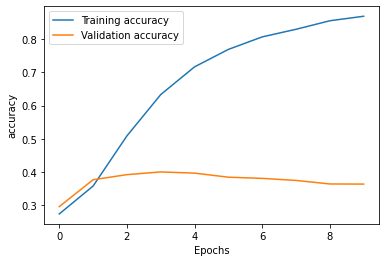

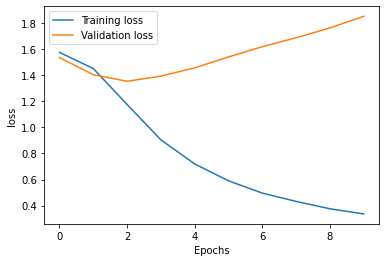

In [77]:
plot_graphs(history1, 'accuracy')
plot_graphs(history1, 'loss')

In [110]:
print('Average Training accuracy ' + str(round(sum(history1.history['accuracy'])/10,2)))
print('Average Validation accuracy ' + str(round(sum(history1.history['val_accuracy'])/10,2)))

Average Training accuracy 0.66
Average Validation accuracy 0.37


The model is grossly overfitted and did not do well for unseen validation data.

In [113]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = tf.keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]
num_epochs = 10

#### RNN - BLSTM

In [114]:
Model2_1 = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(train_vocab, embedding_dim, input_length = max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)), 
  tf.keras.layers.Dropout(0.5), 
  tf.keras.layers.Dense(5, activation="softmax") ])

In [115]:
Model2_1.summary()
Model2_1.compile(loss=loss, optimizer=optim, metrics=metrics)
history2_1 = Model2_1.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=num_epochs,verbose = 1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 140, 100)          7858300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 8,020,105
Trainable params: 8,020,105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
862/862 [==============================] - 322s 298ms/step - loss: 1.1345 - accuracy: 0.5297 - val_

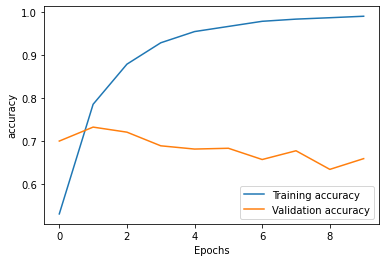

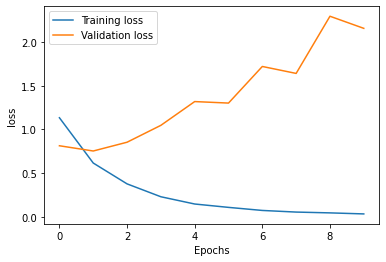

In [116]:
plot_graphs(history2_1, 'accuracy')
plot_graphs(history2_1, 'loss')

In [117]:
print('Average Training accuracy ' + str(round(sum(history2_1.history['accuracy'])/10,2)))
print('Average Validation accuracy ' + str(round(sum(history2_1.history['val_accuracy'])/10,2)))

Average Training accuracy 0.9
Average Validation accuracy 0.68


#### RNN - BLSTM with additional dropout and L2 regularizer

In [118]:
Model2_2 = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(train_vocab, embedding_dim, input_length = max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,dropout = 0.5,recurrent_dropout = 0.5,bias_regularizer=tf.keras.regularizers.L2(0.001))), 
  #L2 Regularizers for avoiding overfitting 
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(5, activation="softmax",kernel_regularizer='l2') ])

In [119]:
Model2_2.summary()
Model2_2.compile(loss=loss, optimizer=optim, metrics=metrics)
history2_2 = Model2_2.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=num_epochs,verbose = 1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 140, 100)          7858300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 8,020,105
Trainable params: 8,020,105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
862/862 [==============================] - 567s 646ms/step - loss: 1.1803 - accuracy: 0.5466 - val_

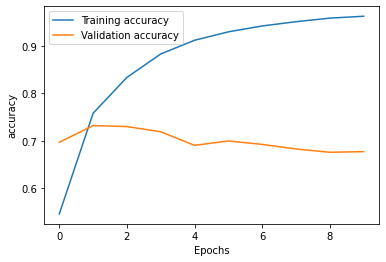

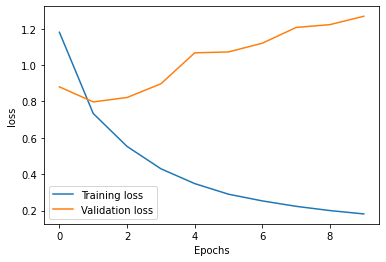

In [120]:
plot_graphs(history2_2, 'accuracy')
plot_graphs(history2_2, 'loss')

In [121]:
print('Average Training accuracy ' + str(round(sum(history2_2.history['accuracy'])/10,2)))
print('Average Validation accuracy ' + str(round(sum(history2_2.history['val_accuracy'])/10,2)))

Average Training accuracy 0.87
Average Validation accuracy 0.7


#### BLSTM with Spatial Dropout 1D

In [159]:
Model3 =  tf.keras.Sequential([
  tf.keras.layers.Embedding(train_vocab, embedding_dim, input_length = max_length),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.SpatialDropout1D(0.5),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.5, recurrent_dropout=0.5)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(5, activation='softmax',kernel_regularizer='l2')])

In [162]:
Model3.summary()
Model3.compile(loss=loss, optimizer=optim, metrics=metrics)
history3 = Model3.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=10,verbose=1)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 140, 100)          7858300   
                                                                 
 dropout_21 (Dropout)        (None, 140, 100)          0         
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 140, 100)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_14 (Bidirecti  (None, 200)              160800    
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 200)               0         
                                                                 
 dense_19 (Dense)            (None, 5)               

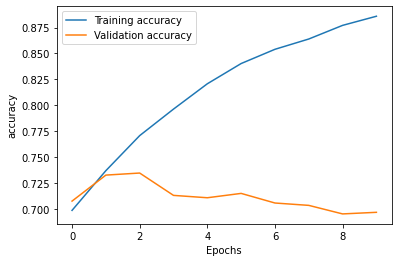

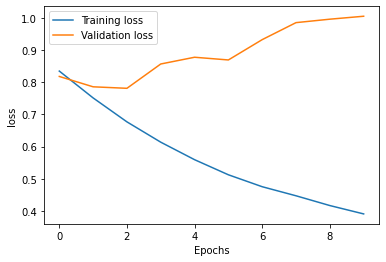

In [166]:
plot_graphs(history3, 'accuracy')
plot_graphs(history3, 'loss')

In [163]:
print('Average Training accuracy ' + str(round(sum(history3.history['accuracy'])/10,2)))
print('Average Validation accuracy ' + str(round(sum(history3.history['val_accuracy'])/10,2)))

Average Training accuracy 0.81
Average Validation accuracy 0.71


### Evaluation - Best model 

> RNN BLSTM with Spatial Drop Out


In [168]:
results = Model3.evaluate(test_padded, test_target_class)

119/119 [==============================] - 11s 92ms/step - loss: 1.2188 - accuracy: 0.6532


In [165]:
from sklearn.metrics import classification_report

predicted = np.argmax(Model3.predict(test_padded), axis=-1)
print(classification_report(test_target_class, predicted))

              precision    recall  f1-score   support

           0       0.81      0.45      0.58       592
           1       0.57      0.67      0.62      1041
           2       0.72      0.78      0.75       619
           3       0.60      0.73      0.66       947
           4       0.80      0.58      0.67       599

    accuracy                           0.65      3798
   macro avg       0.70      0.64      0.65      3798
weighted avg       0.68      0.65      0.65      3798

